In [1]:
library(tidyverse)
library(ggplot2)
library(ggalluvial)
library(rtracklayer)
library(reshape2)
library(patchwork)
library(ggvenn)
library(VennDiagram)
library(eulerr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:b

In [2]:
TE <- import('/u/home/j/jadiruss/project-clarka/Genomes/mm39_STAR/TE/GRCm39_Ensembl_rmsk_TE.gtf')
TE <- as.data.frame(TE)

In [3]:
classes <- c("LTR", "LINE", "SINE")

totals <- TE %>%
    filter(class_id %in% classes) %>%
    group_by(gene_id) %>%
    tally()
cols <- c("gene_id", "total")
colnames(totals) <- cols
head(totals)

gene_id,total
<chr>,<int>
AmnL2-1,1311
AmnSINE1,1379
B1F,42820
B1F1,18133
B1F2,18299
B1_Mm,42591


In [4]:
allTE_class <- TE %>%
    filter(class_id %in% classes) %>%
    group_by(class_id) %>%
    tally()
allTE_class
#
allTE_subclass <- TE %>%
    filter(class_id %in% classes) %>%
    group_by(family_id) %>%
    tally()
allTE_subclass

class_id,n
<chr>,<int>
LINE,976368
LTR,1105064
SINE,1492624


family_id,n
<chr>,<int>
5S-Deu-L2,1379
Alu,558808
B2,370294
B4,380688
CR1,16226
Dong-R4,147
ERV1,69131
ERVK,370031
ERVL,113067


In [5]:
alltimes <- read.delim(file = './align/RPKM_LTRLINESINE_peaks_ATAC_wt_mut.tsv', sep = "\t", header = F)
cols <- c("Chr", "Start", "End", "RPKM_E105_Male", "RPKM_E105_Female", "RPKM_E145_Male", "RPKM_E145_Female","Chr_TE", "Start_TE", "End_TE", "TE_DupID", "TE_Subfamily", "TE_Length", "TE_Strand", "TE_Family", "TE_Class", "Overlap_Size")
colnames(alltimes) <- cols
alltimes <- filter(alltimes, TE_Class %in% classes)
head(alltimes)

,Chr,Start,End,RPKM_E105_Male,RPKM_E105_Female,RPKM_E145_Male,RPKM_E145_Female,Chr_TE,Start_TE,End_TE,TE_DupID,TE_Subfamily,TE_Length,TE_Strand,TE_Family,TE_Class,Overlap_Size
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
1,6,3053222,3053352,0.00000,21.129026,14.415969,39.463540,6,3053148,3053587,MMERVK10C-int_dup1063,MMERVK10C-int,440,+,ERVK,LTR,130
2,6,3094477,3094893,20.90687,43.490973,34.948465,26.734086,6,3094351,3099773,L1MdA_II_dup1634,L1MdA_II,5423,+,L1,LINE,416
3,6,3114764,3114948,3.66240,36.101600,3.150055,3.161196,6,3114681,3114870,L1M5_dup4168,L1M5,190,-,L1,LINE,106
4,6,3116347,3116558,11.72705,32.611081,23.715482,25.196153,6,3116189,3116514,IAPEY4_LTR_dup18,IAPEY4_LTR,326,-,ERVK,LTR,167
5,6,3116347,3116558,11.72705,32.611081,23.715482,25.196153,6,3116515,3116629,B3A_dup29542,B3A,115,+,B2,SINE,43
6,6,3122241,3122395,30.35742,5.460039,19.038086,5.967680,6,3122186,3122273,RMER19B_dup1652,RMER19B,88,-,ERVK,LTR,32


In [6]:
alltimes_dedup <- alltimes %>%
    group_by(Start) %>%
    filter(Overlap_Size == max(Overlap_Size)) %>%
    ungroup() %>%
    group_by(Start_TE) %>%
    filter(Overlap_Size == max(Overlap_Size)) %>%
    ungroup() %>%
    filter(Overlap_Size > 50)
nrow(alltimes)
nrow(alltimes_dedup)
alltimes_dedup

[1] 90598

[1] 73136

Chr,Start,End,RPKM_E105_Male,RPKM_E105_Female,RPKM_E145_Male,RPKM_E145_Female,Chr_TE,Start_TE,End_TE,TE_DupID,TE_Subfamily,TE_Length,TE_Strand,TE_Family,TE_Class,Overlap_Size
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
6,3053222,3053352,0.000000,21.1290257,14.415969,39.463540,6,3053148,3053587,MMERVK10C-int_dup1063,MMERVK10C-int,440,+,ERVK,LTR,130
6,3094477,3094893,20.906874,43.4909727,34.948465,26.734086,6,3094351,3099773,L1MdA_II_dup1634,L1MdA_II,5423,+,L1,LINE,416
6,3114764,3114948,3.662400,36.1015999,3.150055,3.161196,6,3114681,3114870,L1M5_dup4168,L1M5,190,-,L1,LINE,106
6,3116347,3116558,11.727053,32.6110810,23.715482,25.196153,6,3116189,3116514,IAPEY4_LTR_dup18,IAPEY4_LTR,326,-,ERVK,LTR,167
6,3151613,3152479,69.583813,75.3137924,33.152461,29.768201,6,3152217,3152731,RLTR11A2_dup880,RLTR11A2,515,+,ERVK,LTR,262
6,3159669,3160168,20.140838,27.4946430,19.881717,10.677392,6,3159405,3163771,MMETn-int_dup205,MMETn-int,4367,-,ERVK,LTR,499
6,3163938,3164151,4.547910,4.7371606,68.936469,21.682594,6,3163772,3164092,RLTRETN_Mm_dup367,RLTRETN_Mm,321,-,ERVK,LTR,154
6,3190517,3190680,0.000000,9.7153207,53.693969,124.575642,6,3184986,3191444,IAPEz-int_dup2352,IAPEz-int,6459,-,ERVK,LTR,163
6,3194133,3194488,12.101344,38.3513586,9.905062,12.026466,6,3194159,3194344,B3_dup46210,B3,186,+,B2,SINE,185


In [7]:
alltimes_dedup_label <- alltimes_dedup %>% 
    mutate(Case_E105_Male = case_when(((RPKM_E105_Male >= 15) ~ "Open"), TRUE ~ "Closed")) %>%
    mutate(Case_E105_Female = case_when(((RPKM_E105_Female >= 15) ~ "Open"), TRUE ~ "Closed")) %>%
    mutate(Case_E145_Male = case_when(((RPKM_E145_Male >= 15) ~ "Open"), TRUE ~ "Closed")) %>%
    mutate(Case_E145_Female = case_when(((RPKM_E145_Female >= 15) ~ "Open"), TRUE ~ "Closed"))

colnames(alltimes_dedup_label)
keep <- c(1,2,3,11,12,15,16,18:21)
alltimes_dedup_label_status_only <- alltimes_dedup_label[,keep]
head(alltimes_dedup_label_status_only)

[1] "Chr"              "Start"            "End"              "RPKM_E105_Male"  
 [5] "RPKM_E105_Female" "RPKM_E145_Male"   "RPKM_E145_Female" "Chr_TE"          
 [9] "Start_TE"         "End_TE"           "TE_DupID"         "TE_Subfamily"    
[13] "TE_Length"        "TE_Strand"        "TE_Family"        "TE_Class"        
[17] "Overlap_Size"     "Case_E105_Male"   "Case_E105_Female" "Case_E145_Male"  
[21] "Case_E145_Female"

Chr,Start,End,TE_DupID,TE_Subfamily,TE_Family,TE_Class,Case_E105_Male,Case_E105_Female,Case_E145_Male,Case_E145_Female
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
6,3053222,3053352,MMERVK10C-int_dup1063,MMERVK10C-int,ERVK,LTR,Closed,Open,Closed,Open
6,3094477,3094893,L1MdA_II_dup1634,L1MdA_II,L1,LINE,Open,Open,Open,Open
6,3114764,3114948,L1M5_dup4168,L1M5,L1,LINE,Closed,Open,Closed,Closed
6,3116347,3116558,IAPEY4_LTR_dup18,IAPEY4_LTR,ERVK,LTR,Closed,Open,Open,Open
6,3151613,3152479,RLTR11A2_dup880,RLTR11A2,ERVK,LTR,Open,Open,Open,Open
6,3159669,3160168,MMETn-int_dup205,MMETn-int,ERVK,LTR,Open,Open,Open,Closed


In [8]:
colnames(alltimes_dedup_label_status_only)
males <- c(1:7,8,10)
labels_male <- alltimes_dedup_label_status_only[,males]
labels_male
#
females <- c(1:7,9,11)
labels_female <- alltimes_dedup_label_status_only[,females]
labels_female

[1] "Chr"              "Start"            "End"              "TE_DupID"        
 [5] "TE_Subfamily"     "TE_Family"        "TE_Class"         "Case_E105_Male"  
 [9] "Case_E105_Female" "Case_E145_Male"   "Case_E145_Female"

Chr,Start,End,TE_DupID,TE_Subfamily,TE_Family,TE_Class,Case_E105_Male,Case_E145_Male
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
6,3053222,3053352,MMERVK10C-int_dup1063,MMERVK10C-int,ERVK,LTR,Closed,Closed
6,3094477,3094893,L1MdA_II_dup1634,L1MdA_II,L1,LINE,Open,Open
6,3114764,3114948,L1M5_dup4168,L1M5,L1,LINE,Closed,Closed
6,3116347,3116558,IAPEY4_LTR_dup18,IAPEY4_LTR,ERVK,LTR,Closed,Open
6,3151613,3152479,RLTR11A2_dup880,RLTR11A2,ERVK,LTR,Open,Open
6,3159669,3160168,MMETn-int_dup205,MMETn-int,ERVK,LTR,Open,Open
6,3163938,3164151,RLTRETN_Mm_dup367,RLTRETN_Mm,ERVK,LTR,Closed,Open
6,3190517,3190680,IAPEz-int_dup2352,IAPEz-int,ERVK,LTR,Closed,Open
6,3194133,3194488,B3_dup46210,B3,B2,SINE,Closed,Closed


Chr,Start,End,TE_DupID,TE_Subfamily,TE_Family,TE_Class,Case_E105_Female,Case_E145_Female
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
6,3053222,3053352,MMERVK10C-int_dup1063,MMERVK10C-int,ERVK,LTR,Open,Open
6,3094477,3094893,L1MdA_II_dup1634,L1MdA_II,L1,LINE,Open,Open
6,3114764,3114948,L1M5_dup4168,L1M5,L1,LINE,Open,Closed
6,3116347,3116558,IAPEY4_LTR_dup18,IAPEY4_LTR,ERVK,LTR,Open,Open
6,3151613,3152479,RLTR11A2_dup880,RLTR11A2,ERVK,LTR,Open,Open
6,3159669,3160168,MMETn-int_dup205,MMETn-int,ERVK,LTR,Open,Closed
6,3163938,3164151,RLTRETN_Mm_dup367,RLTRETN_Mm,ERVK,LTR,Closed,Open
6,3190517,3190680,IAPEz-int_dup2352,IAPEz-int,ERVK,LTR,Closed,Open
6,3194133,3194488,B3_dup46210,B3,B2,SINE,Open,Closed


Case_E105_Male,Case_E145_Male,n
<chr>,<chr>,<int>
Closed,Closed,18336
Closed,Open,16202
Open,Closed,12469
Open,Open,26129


Case_E105_Female,Case_E145_Female,n
<chr>,<chr>,<int>
Closed,Closed,3638
Closed,Open,10368
Open,Closed,27053
Open,Open,32077


Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


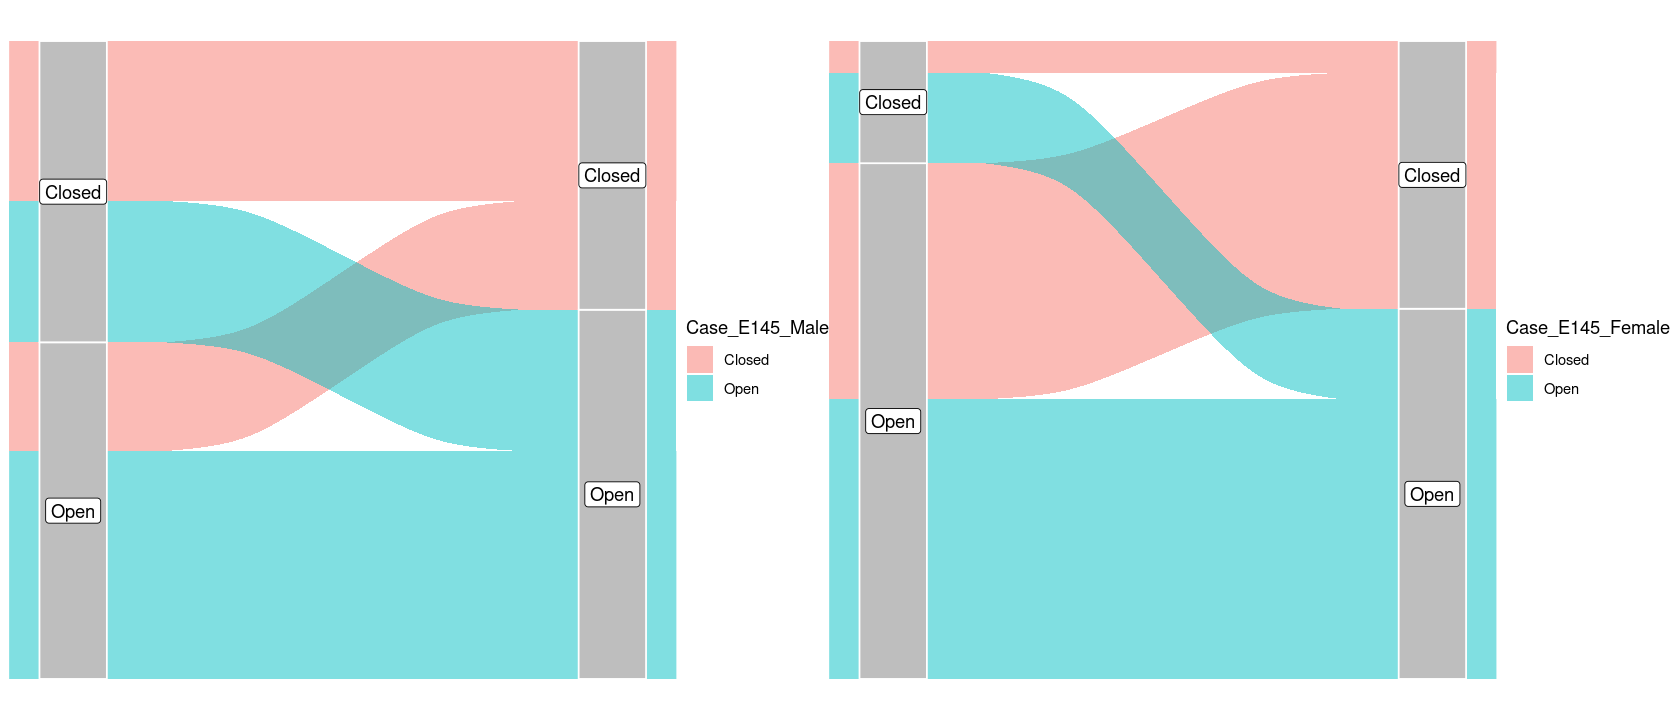

In [25]:
#cols <- c("Case_E105", "Case_E145", "n", "Sex")

tally_male <- alltimes_dedup_label_status_only %>%
    group_by(Case_E105_Male, Case_E145_Male) %>%
    tally()
tally_male

tally_female <- alltimes_dedup_label_status_only %>%
    group_by(Case_E105_Female, Case_E145_Female) %>%
    tally()
tally_female
#
options(repr.plot.height = 6, repr.plot.width = 14)
p1 <- ggplot(as.data.frame(tally_male),aes(y = n, axis1 = Case_E105_Male, axis2 = Case_E145_Male)) + geom_alluvium(aes(fill = Case_E145_Male)) +  geom_stratum(width = 1/8, fill = "grey", color = "white") +
  geom_label(stat = "stratum", aes(label = after_stat(stratum))) + theme_void()

p2 <- ggplot(as.data.frame(tally_female),aes(y = n, axis1 = Case_E105_Female, axis2 = Case_E145_Female)) + geom_alluvium(aes(fill = Case_E145_Female)) +  geom_stratum(width = 1/8, fill = "grey", color = "white") +
  geom_label(stat = "stratum", aes(label = after_stat(stratum))) + theme_void()

p1 + p2

#pdf(file = 'E105_WT_E145_WT_10-6_short.pdf', height = 4, width = 14)
#print(p1 + p2)
#dev.off()

In [10]:
nrow(labels_male)

male_OC <- labels_male %>%
    filter(Case_E105_Male == "Open" & Case_E145_Male == "Closed") %>%
    group_by(TE_Subfamily) %>%
    tally()
#
male_OC <- inner_join(male_OC, totals, by = c("TE_Subfamily" = "gene_id"))
male_OC$percent <- (male_OC$n/male_OC$total) * 100
male_OC$peak_rep <- (male_OC$n/sum(male_OC$n)) * 100
male_OC <- male_OC[order(male_OC$percent, decreasing = T), ]
male_OC

[1] 73136

TE_Subfamily,n,total,percent,peak_rep
<chr>,<int>,<int>,<dbl>,<dbl>
RLTR9D2,38,191,19.895288,0.304755794
ERVB7_4-LTR_MM,33,177,18.644068,0.264656348
RLTR9B2,21,168,12.500000,0.168417676
RLTR13F,14,117,11.965812,0.112278451
RLTR9D,89,763,11.664482,0.713770150
RLTR13E,59,543,10.865562,0.473173470
RLTR13D6,77,804,9.577114,0.617531478
RLTR9E,109,1281,8.508977,0.874167936
RLTR9B,17,203,8.374384,0.136338119


In [11]:
nrow(labels_male)

male_CO <- labels_male %>%
    filter(Case_E105_Male == "Closed" & Case_E145_Male == "Open") %>%
    group_by(TE_Subfamily) %>%
    tally()
#
male_CO <- inner_join(male_CO, totals, by = c("TE_Subfamily" = "gene_id"))
male_CO$percent <- (male_CO$n/male_CO$total) * 100
male_CO$peak_rep <- (male_CO$n/sum(male_CO$n)) * 100
male_CO <- male_CO[order(male_CO$percent, decreasing = T), ]
male_CO

[1] 73136

TE_Subfamily,n,total,percent,peak_rep
<chr>,<int>,<int>,<dbl>,<dbl>
RMER3D1,1,2,50.000000,0.006172078
RLTR10C,661,1762,37.514188,4.079743242
RLTR10B2,277,863,32.097335,1.709665473
RLTR44E,15,126,11.904762,0.092581163
RLTR44C,21,200,10.500000,0.129613628
IAP1-MM_LTR,44,420,10.476190,0.271571411
RLTR44B,16,155,10.322581,0.098753240
RLTR1D2_MM,17,181,9.392265,0.104925318
RLTR10A,74,809,9.147095,0.456733737


In [12]:
nrow(labels_male)

male_OO <- labels_male %>%
    filter(Case_E105_Male == "Open" & Case_E145_Male == "Open") %>%
    group_by(TE_Subfamily) %>%
    tally()
#
male_OO <- inner_join(male_OO, totals, by = c("TE_Subfamily" = "gene_id"))
male_OO$percent <- (male_OO$n/male_OO$total) * 100
male_OO$peak_rep <- (male_OO$n/sum(male_OO$n)) * 100
male_OO <- male_OO[order(male_OO$percent, decreasing = T), ]
male_OO

[1] 73136

TE_Subfamily,n,total,percent,peak_rep
<chr>,<int>,<int>,<dbl>,<dbl>
IAPEY4_LTR,35,97,36.08247,0.13395078
RLTR10C,611,1762,34.67650,2.33839795
RLTR44C,65,200,32.50000,0.24876574
RLTR13D6,250,804,31.09453,0.95679130
ERVB7_4-LTR_MM,55,177,31.07345,0.21049409
RLTR44E,39,126,30.95238,0.14925944
RLTR44D,29,100,29.00000,0.11098779
L1MdTf_I,647,2613,24.76081,2.47617590
RLTR13E,124,543,22.83610,0.47456849


In [13]:
nrow(labels_male)

male_CC <- labels_male %>%
    filter(Case_E105_Male == "Closed" & Case_E145_Male == "Closed") %>%
    group_by(TE_Subfamily) %>%
    tally()
#
male_CC <- inner_join(male_CC, totals, by = c("TE_Subfamily" = "gene_id"))
male_CC$percent <- (male_CC$n/male_CC$total) * 100
male_CC$peak_rep <- (male_CC$n/sum(male_CC$n)) * 100
male_CC <- male_CC[order(male_CC$percent, decreasing = T), ]
male_CC

[1] 73136

TE_Subfamily,n,total,percent,peak_rep
<chr>,<int>,<int>,<dbl>,<dbl>
LTR108a_Mam,2,35,5.714286,0.010907504
L1MdA_II,270,5350,5.046729,1.472513089
L1MdA_I,226,4683,4.825966,1.232547993
LTR88a,3,66,4.545455,0.016361257
RLTR13A2,7,163,4.294479,0.038176265
RLTR13F,5,117,4.273504,0.027268761
L1MdTf_II,142,3801,3.735859,0.774432810
L1MdA_III,299,8615,3.470691,1.630671902
LTR108d_Mam,1,30,3.333333,0.005453752


In [14]:
nrow(labels_male)

female_OC <- labels_female %>%
    filter(Case_E105_Female == "Open" & Case_E145_Female == "Closed") %>%
    group_by(TE_Subfamily) %>%
    tally()
#
female_OC <- inner_join(female_OC, totals, by = c("TE_Subfamily" = "gene_id"))
female_OC$percent <- (female_OC$n/female_OC$total) * 100
female_OC$peak_rep <- (female_OC$n/sum(female_OC$n)) * 100
female_OC <- female_OC[order(female_OC$percent, decreasing = T), ]
female_OC

[1] 73136

TE_Subfamily,n,total,percent,peak_rep
<chr>,<int>,<int>,<dbl>,<dbl>
RLTR9D2,39,191,20.418848,0.144161461
RLTR13D6,149,804,18.532338,0.550770709
RLTR9D,119,763,15.596330,0.439877278
RLTR13E,78,543,14.364641,0.288322922
RLTR13F,15,117,12.820513,0.055446716
RLTR9E,150,1281,11.709602,0.554467157
RLTR9B2,19,168,11.309524,0.070232507
ERVB7_4-LTR_MM,20,177,11.299435,0.073928954
RLTR44D,10,100,10.000000,0.036964477


In [15]:
nrow(labels_male)

female_CO <- labels_female %>%
    filter(Case_E105_Female == "Closed" & Case_E145_Female == "Open") %>%
    group_by(TE_Subfamily) %>%
    tally()
#
female_CO <- inner_join(female_CO, totals, by = c("TE_Subfamily" = "gene_id"))
female_CO$percent <- (female_CO$n/female_CO$total) * 100
female_CO$peak_rep <- (female_CO$n/sum(female_CO$n)) * 100
female_CO <- female_CO[order(female_CO$percent, decreasing = T), ]
female_CO

[1] 73136

TE_Subfamily,n,total,percent,peak_rep
<chr>,<int>,<int>,<dbl>,<dbl>
RLTR10C,559,1762,31.725312,5.39158951
RLTR10B2,211,863,24.449594,2.03510802
RLTR44C,21,200,10.500000,0.20254630
RLTR1D2_MM,19,181,10.497238,0.18325617
RLTR44E,12,126,9.523810,0.11574074
IAP1-MM_LTR,34,420,8.095238,0.32793210
RLTR44B,12,155,7.741935,0.11574074
RLTR44D,7,100,7.000000,0.06751543
IAPEY4_LTR,6,97,6.185567,0.05787037


In [16]:
nrow(labels_male)

female_OO <- labels_female %>%
    filter(Case_E105_Female == "Open" & Case_E145_Female == "Open") %>%
    group_by(TE_Subfamily) %>%
    tally()
#
female_OO <- inner_join(female_OO, totals, by = c("TE_Subfamily" = "gene_id"))
female_OO$percent <- (female_OO$n/female_OO$total) * 100
female_OO$peak_rep <- (female_OO$n/sum(female_OO$n)) * 100
female_OO <- female_OO[order(female_OO$percent, decreasing = T), ]
female_OO

[1] 73136

TE_Subfamily,n,total,percent,peak_rep
<chr>,<int>,<int>,<dbl>,<dbl>
ERVB7_4-LTR_MM,69,177,38.983051,0.215107398
RLTR10C,642,1762,36.435868,2.001434049
IAPEY4_LTR,35,97,36.082474,0.109112448
L1MdTf_I,769,2613,29.429774,2.397356361
RLTR44E,36,126,28.571429,0.112229947
RLTR44C,51,200,25.500000,0.158992424
L1MdTf_II,932,3801,24.519863,2.905508620
RLTR13D6,179,804,22.263682,0.558032235
RLTR13E,112,543,20.626151,0.349159834


In [17]:
nrow(labels_male)

female_CC <- labels_female %>%
    filter(Case_E105_Female == "Closed" & Case_E145_Female == "Closed") %>%
    group_by(TE_Subfamily) %>%
    tally()
#
female_CC <- inner_join(female_CC, totals, by = c("TE_Subfamily" = "gene_id"))
female_CC$percent <- (female_CC$n/female_CC$total) * 100
female_CC$peak_rep <- (female_CC$n/sum(female_CC$n)) * 100
female_CC <- female_CC[order(female_CC$percent, decreasing = T), ]
female_CC

[1] 73136

TE_Subfamily,n,total,percent,peak_rep
<chr>,<int>,<int>,<dbl>,<dbl>
RMER3D1,1,2,50.000000,0.02748763
RLTR10B2,73,863,8.458864,2.00659703
IAP1-MM_LTR,18,420,4.285714,0.49477735
IAPEY5_LTR,9,235,3.829787,0.24738868
RLTR44B,5,155,3.225806,0.13743815
IAPLTR2b,37,1232,3.003247,1.01704233
RLTR10C,45,1762,2.553916,1.23694338
RLTR44C,5,200,2.500000,0.13743815
MARE6,1,41,2.439024,0.02748763


In [18]:
male_CO <- male_CO[1:10,]
male_OC <- male_OC[1:10,]
male_OO <- male_OO[1:10,]
male_CC <- male_CC[1:10,]
#
female_CO <- female_CO[1:10,]
female_OC <- female_OC[1:10,]
female_OO <- female_OO[1:10,]
female_CC <- female_CC[1:10,]

png 
  2

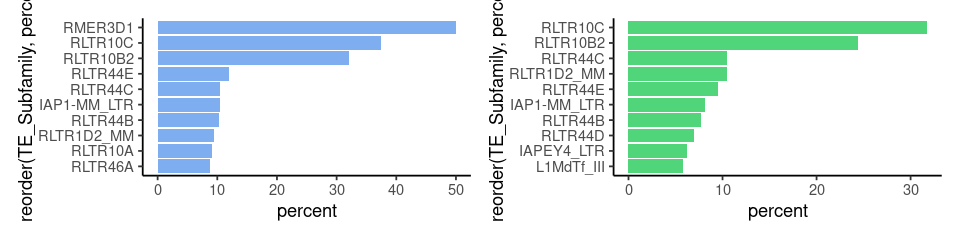

png 
  2

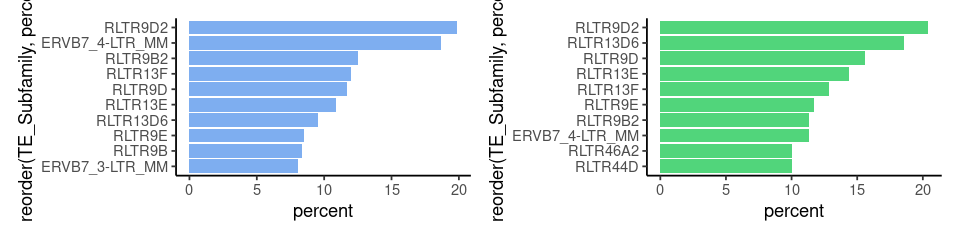

png 
  2

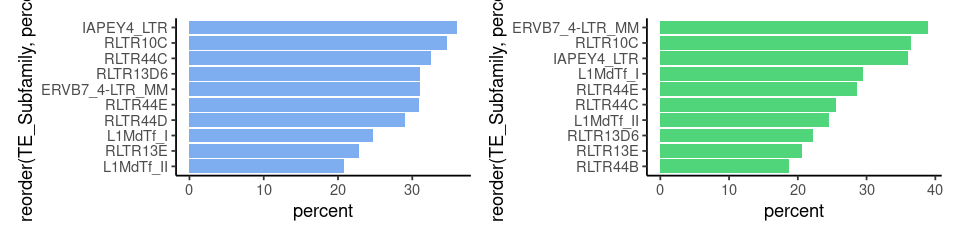

png 
  2

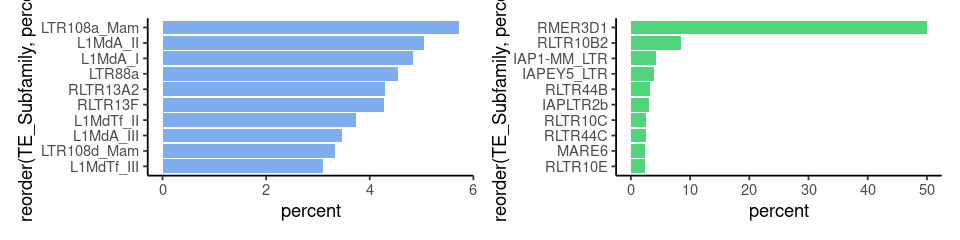

In [21]:
options(repr.plot.height = 2, repr.plot.width = 8)
p1 <- ggplot(male_CO, aes(reorder(TE_Subfamily, percent), percent)) + geom_bar(stat = "identity", fill = c("#7eaef0")) + coord_flip() + theme_classic()
p2 <- ggplot(female_CO, aes(reorder(TE_Subfamily, percent), percent)) + geom_bar(stat = "identity", fill = c("#51d57b")) + coord_flip() + theme_classic()
p1 + p2

pdf(file = 'E105_WT_CO_10-14_short.pdf', width = 8, height = 2)
p1 + p2
dev.off()
#
p1 <- ggplot(male_OC, aes(reorder(TE_Subfamily, percent), percent)) + geom_bar(stat = "identity", fill = c("#7eaef0")) + coord_flip() + theme_classic()
p2 <- ggplot(female_OC, aes(reorder(TE_Subfamily, percent), percent)) + geom_bar(stat = "identity", fill = c("#51d57b")) + coord_flip() + theme_classic()
p1 + p2

pdf(file = 'E105_WT_OC_10-14_short.pdf', width = 8, height = 2)
p1 + p2
dev.off()

p1 <- ggplot(male_OO, aes(reorder(TE_Subfamily, percent), percent)) + geom_bar(stat = "identity", fill = c("#7eaef0")) + coord_flip() + theme_classic()
p2 <- ggplot(female_OO, aes(reorder(TE_Subfamily, percent), percent)) + geom_bar(stat = "identity", fill = c("#51d57b")) + coord_flip() + theme_classic()
p1 + p2

pdf(file = 'E105_WT_OO_10-14_short.pdf', width = 8, height = 2)
p1 + p2
dev.off()

p1 <- ggplot(male_CC, aes(reorder(TE_Subfamily, percent), percent)) + geom_bar(stat = "identity", fill = c("#7eaef0")) + coord_flip() + theme_classic()
p2 <- ggplot(female_CC, aes(reorder(TE_Subfamily, percent), percent)) + geom_bar(stat = "identity", fill = c("#51d57b")) + coord_flip() + theme_classic()
p1 + p2

pdf(file = 'E105_WT_CC_10-14_short.pdf', width = 8, height = 2)
p1 + p2
dev.off()

In [10]:
#Save BED with O-C and C-O conditions for Male and Female to look for H3K27ac enrichment. 

male_OC <- labels_male %>%
    filter(Case_E105_Male == "Open" & Case_E145_Male == "Closed")
male_OC <- male_OC[,1:7]
write.table(male_OC, file = 'Male_OC_WTonly.bed', row.names = F, col.names = F, quote = F, sep = "\t")
#
male_CO <- labels_male %>%
    filter(Case_E105_Male == "Closed" & Case_E145_Male == "Open")
male_CO <- male_CO[,1:7]
write.table(male_CO, file = 'Male_CO_WTonly.bed', row.names = F, col.names = F, quote = F, sep = "\t")

male_OO <- labels_male %>%
    filter(Case_E105_Male == "Open" & Case_E145_Male == "Open")
male_OO <- male_OO[,1:7]
write.table(male_OO, file = 'Male_OO_WTonly.bed', row.names = F, col.names = F, quote = F, sep = "\t")
#
male_CC <- labels_male %>%
    filter(Case_E105_Male == "Closed" & Case_E145_Male == "Closed")
male_CC <- male_CC[,1:7]
write.table(male_CC, file = 'Male_CC_WTonly.bed', row.names = F, col.names = F, quote = F, sep = "\t")



#
female_OC <- labels_female %>%
    filter(Case_E105_Female == "Open" & Case_E145_Female == "Closed")
female_OC <- female_OC[,1:7]
write.table(female_OC, file = 'Female_OC_WTonly.bed', row.names = F, col.names = F, quote = F, sep = "\t")
#
female_CO <- labels_female %>%
    filter(Case_E105_Female == "Closed" & Case_E145_Female == "Open")
female_CO <- female_CO[,1:7]
write.table(female_CO, file = 'Female_CO_WTonly.bed', row.names = F, col.names = F, quote = F, sep = "\t")


female_OO <- labels_female %>%
    filter(Case_E105_Female == "Open" & Case_E145_Female == "Open")
female_OO <- female_OO[,1:7]
write.table(female_OO, file = 'Female_OO_WTonly.bed', row.names = F, col.names = F, quote = F, sep = "\t")
#
female_CC <- labels_female %>%
    filter(Case_E105_Female == "Closed" & Case_E145_Female == "Closed")
female_CC <- female_CC[,1:7]
write.table(female_CC, file = 'Female_CC_WTonly.bed', row.names = F, col.names = F, quote = F, sep = "\t")

In [92]:
#Now look at the class build of all these catagories, starting with genomic background

class_males_OC <- labels_male %>%
    filter(Case_E105_Male == "Open" & Case_E145_Male == "Closed") %>%
    group_by(TE_Class) %>%
    tally()

class_males_CO <- labels_male %>%
    filter(Case_E105_Male == "Closed" & Case_E145_Male == "Open") %>%
    group_by(TE_Class) %>%
    tally()

class_males_CC <- labels_male %>%
    filter(Case_E105_Male == "Closed" & Case_E145_Male == "Closed") %>%
    group_by(TE_Class) %>%
    tally()

class_males_OO <- labels_male %>%
    filter(Case_E105_Male == "Open" & Case_E145_Male == "Open") %>%
    group_by(TE_Class) %>%
    tally()

class_males <- labels_male %>%
    group_by(TE_Class) %>%
    tally()

allTE_class <- TE %>%
    filter(class_id %in% classes) %>%
    group_by(class_id) %>%
    tally()

class_males_OC$percent <- class_males_OC$n/(sum(class_males_OC$n)) * 100
class_males_OC$Condition <- c("OC")
class_males_OC$Sex <- c("XY")
#class_males_OC

class_males_CO$percent <- class_males_CO$n/(sum(class_males_CO$n)) * 100
class_males_CO$Condition <- c("CO")
class_males_CO$Sex <- c("XY")
#class_males_CO

class_males_CC$percent <- class_males_CC$n/(sum(class_males_CC$n)) * 100
class_males_CC$Condition <- c("CC")
class_males_CC$Sex <- c("XY")
#class_males_CC

class_males_OO$percent <- class_males_OO$n/(sum(class_males_OO$n)) * 100
class_males_OO$Condition <- c("OO")
class_males_OO$Sex <- c("XY")
#class_males_OO

class_males$percent <- class_males$n/(sum(class_males$n)) * 100
class_males$Condition <- c("ATAC_peaks")
class_males$Sex <- c("XY")
cols <- c("TE_Class", "n", "percent", "Condition", "Sex")
colnames(class_males) <- cols

allTE_class$percent <- allTE_class$n/(sum(allTE_class$n)) * 100
allTE_class$Condition <- c("All_LTRLINESINE")
allTE_class$Sex <- c("XY")
colnames(allTE_class) <- cols
allTE_class

TE_Class,n,percent,Condition,Sex
<chr>,<int>,<dbl>,<chr>,<chr>
LINE,976368,27.31821,All_LTRLINESINE,XY
LTR,1105064,30.91905,All_LTRLINESINE,XY
SINE,1492624,41.76275,All_LTRLINESINE,XY


In [93]:
all_male <- bind_rows(class_males_OC, class_males_CO)
all_male <- bind_rows(all_male, class_males_CC)
all_male <- bind_rows(all_male, class_males_OO)
all_male <- bind_rows(all_male, class_males)
all_male <- bind_rows(all_male, allTE_class)
all_male

TE_Class,n,percent,Condition,Sex
<chr>,<int>,<dbl>,<chr>,<chr>
LINE,2796,22.42361,OC,XY
LTR,5658,45.37653,OC,XY
SINE,4015,32.19986,OC,XY
LINE,4621,28.52117,CO,XY
LTR,7109,43.87730,CO,XY
SINE,4472,27.60153,CO,XY
LINE,5743,31.32090,CC,XY
LTR,6333,34.53861,CC,XY
SINE,6260,34.14049,CC,XY


In [94]:
class_females_OC <- labels_female %>%
    filter(Case_E105_Female == "Open" & Case_E145_Female == "Closed") %>%
    group_by(TE_Class) %>%
    tally()

class_females_CO <- labels_female %>%
    filter(Case_E105_Female == "Closed" & Case_E145_Female == "Open") %>%
    group_by(TE_Class) %>%
    tally()

class_females_CC <- labels_female %>%
    filter(Case_E105_Female == "Closed" & Case_E145_Female == "Closed") %>%
    group_by(TE_Class) %>%
    tally()

class_females_OO <- labels_female %>%
    filter(Case_E105_Female == "Open" & Case_E145_Female == "Open") %>%
    group_by(TE_Class) %>%
    tally()

class_females <- labels_female %>%
    group_by(TE_Class) %>%
    tally()

allTE_class <- TE %>%
    filter(class_id %in% classes) %>%
    group_by(class_id) %>%
    tally()

class_females_OC$percent <- class_females_OC$n/(sum(class_females_OC$n)) * 100
class_females_OC$Condition <- c("OC")
class_females_OC$Sex <- c("XX")

class_females_CO$percent <- class_females_CO$n/(sum(class_females_CO$n)) * 100
class_females_CO$Condition <- c("CO")
class_females_CO$Sex <- c("XX")

class_females_CC$percent <- class_females_CC$n/(sum(class_females_CC$n)) * 100
class_females_CC$Condition <- c("CC")
class_females_CC$Sex <- c("XX")

class_females_OO$percent <- class_females_OO$n/(sum(class_females_OO$n)) * 100
class_females_OO$Condition <- c("OO")
class_females_OO$Sex <- c("XX")

class_females$percent <- class_females$n/(sum(class_females$n)) * 100
class_females$Condition <- c("ATAC_peaks")
class_females$Sex <- c("XX")

allTE_class$percent <- allTE_class$n/(sum(allTE_class$n)) * 100
allTE_class$Condition <- c("All_LTRLINESINE")
allTE_class$Sex <- c("XX")

allTE_class$percent <- allTE_class$n/(sum(allTE_class$n)) * 100
allTE_class$Condition <- c("All_LTRLINESINE")
allTE_class$Sex <- c("XX")
colnames(allTE_class) <- cols
allTE_class

TE_Class,n,percent,Condition,Sex
<chr>,<int>,<dbl>,<chr>,<chr>
LINE,976368,27.31821,All_LTRLINESINE,XX
LTR,1105064,30.91905,All_LTRLINESINE,XX
SINE,1492624,41.76275,All_LTRLINESINE,XX


In [95]:
all_female <- bind_rows(class_females_OC, class_females_CO)
all_female <- bind_rows(all_female, class_females_CC)
all_female <- bind_rows(all_female, class_females_OO)
all_female <- bind_rows(all_female, class_females)
all_female <- bind_rows(all_female, allTE_class)
all_female

TE_Class,n,percent,Condition,Sex
<chr>,<int>,<dbl>,<chr>,<chr>
LINE,7427,27.45352,OC,XX
LTR,11205,41.41870,OC,XX
SINE,8421,31.12779,OC,XX
LINE,2601,25.08681,CO,XX
LTR,4713,45.45718,CO,XX
SINE,3054,29.45602,CO,XX
LINE,906,24.90379,CC,XX
LTR,1768,48.59813,CC,XX
SINE,964,26.49808,CC,XX


In [100]:
plot_percent <- bind_rows(all_male, all_female)
plot_percent
plot_percent$Sex_f <- factor(plot_percent$Sex, levels = c("XY", "XX"))

TE_Class,n,percent,Condition,Sex
<chr>,<int>,<dbl>,<chr>,<chr>
LINE,2796,22.42361,OC,XY
LTR,5658,45.37653,OC,XY
SINE,4015,32.19986,OC,XY
LINE,4621,28.52117,CO,XY
LTR,7109,43.87730,CO,XY
SINE,4472,27.60153,CO,XY
LINE,5743,31.32090,CC,XY
LTR,6333,34.53861,CC,XY
SINE,6260,34.14049,CC,XY


png 
  2

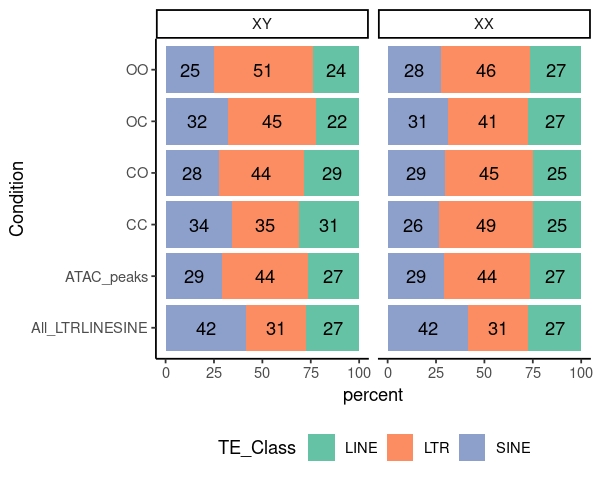

In [102]:
options(repr.plot.height = 4, repr.plot.width = 5)
p1 <- ggplot(plot_percent, aes(x = percent, y = Condition, fill = TE_Class)) + 
geom_bar(stat = "identity", position = "stack") + 
facet_grid(~Sex_f) + 
geom_text(aes(label=round(percent)), position = position_stack(vjust = .5)) +
theme_classic() + 
scale_fill_brewer(palette = "Set2") + 
theme(legend.position = "bottom")
p1

pdf(file = 'Class_percent_WT_LTRpeaks.pdf', width = 5, height = 4)
p1
dev.off()

In [14]:
chroms_XY_O_E105 <- labels_male %>%
    filter(Case_E105_Male == "Open") %>%
    group_by(Chr) %>%
    tally()
chroms_XY_O_E105$Sex <- c("XY")
chroms_XY_O_E105$Time <- c("E10.5")
#
chroms_XY_O_E145 <- labels_male %>%
    filter(Case_E145_Male == "Open") %>%
    group_by(Chr) %>%
    tally()
chroms_XY_O_E145$Sex <- c("XY")
chroms_XY_O_E145$Time <- c("E14.5")
#
chroms_XX_O_E105 <- labels_female %>%
    filter(Case_E105_Female == "Open") %>%
    group_by(Chr) %>%
    tally()
chroms_XX_O_E105$Sex <- c("XX")
chroms_XX_O_E105$Time <- c("E10.5")
#
chroms_XX_O_E145 <- labels_female %>%
    filter(Case_E145_Female == "Open") %>%
    group_by(Chr) %>%
    tally()
chroms_XX_O_E145$Sex <- c("XX")
chroms_XX_O_E145$Time <- c("E14.5")
#

In [15]:
chrom_tally <- TE %>%
    group_by(seqnames) %>%
    tally() %>%
    filter(seqnames %in% order)
chrom_tally

seqnames,n
<fct>,<int>
1,266428
2,255540
3,205952
4,230716
5,226035
6,204432
7,216783
8,177862
9,185892


In [16]:
chroms <- list(chroms_XY_O_E105, chroms_XY_O_E145, chroms_XX_O_E105, chroms_XX_O_E145)
all_con <- bind_rows(chroms)
order <- c(1:19, "X", "Y")
order
all_con$Chr <- factor(all_con$Chr, levels = all_con$Chr[order(order)])
all_con

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "X"  "Y"

Chr,n,Sex,Time
<fct>,<int>,<chr>,<chr>
1,2896,XY,E10.5
10,2235,XY,E10.5
11,1659,XY,E10.5
12,1745,XY,E10.5
13,1812,XY,E10.5
14,1698,XY,E10.5
15,1519,XY,E10.5
16,1376,XY,E10.5
17,1718,XY,E10.5


In [17]:
all_ratio <- inner_join(all_con, chrom_tally, by = c("Chr" = "seqnames"))
all_ratio$ratio <- all_ratio$n.x/all_ratio$n.y
all_ratio

Chr,n.x,Sex,Time,n.y,ratio
<fct>,<int>,<chr>,<chr>,<int>,<dbl>
1,2896,XY,E10.5,266428,0.010869728
10,2235,XY,E10.5,179085,0.012480107
11,1659,XY,E10.5,198666,0.008350699
12,1745,XY,E10.5,165405,0.010549862
13,1812,XY,E10.5,158700,0.011417769
14,1698,XY,E10.5,160781,0.010560949
15,1519,XY,E10.5,138766,0.010946485
16,1376,XY,E10.5,130395,0.010552552
17,1718,XY,E10.5,132922,0.012924873


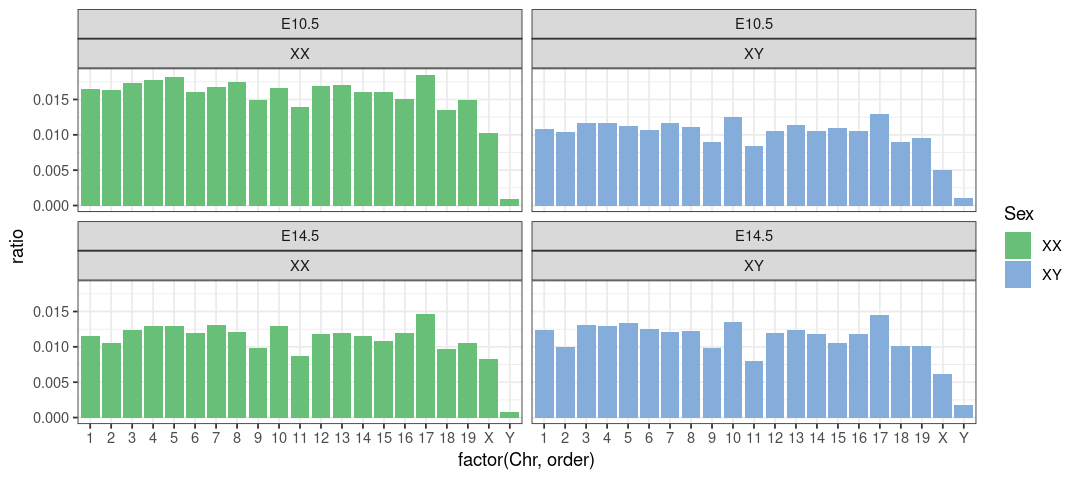

In [26]:
options(repr.plot.width = 9, repr.plot.height = 4)
p1 <- ggplot(all_ratio, aes(factor(Chr, order), ratio, fill = Sex)) + geom_bar(stat = "identity", position = "stack") + facet_wrap(~ Time + Sex) + 
    scale_fill_manual(values = c("#68C078", "#85ADDC")) +
    theme_bw()
p1

In [28]:
pdf(file = 'ATAC_Open_E105_E145_byChr_ratio_rev2.pdf', height = 4, width = 9)
p1
dev.off()

png 
  2